# Assignment 3 Question 2

## Introduction

This tutorial demonstrates the basic workflow of using TensorFlow with a simple linear model. After loading the so-called MNIST data-set with images of hand-written digits, we define and train a simple mathematical model in TensorFlow. The results are then plotted and discussed.

You should be familiar with basic linear algebra, Python and the Jupyter Notebook editor. It also helps if you have a basic understanding of Machine Learning and classification.

## Imports

In [0]:
%tensorflow_version 1.x" before "import tensorflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x" before "import tensorflow`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Check TensorFlow version:

In [0]:
tf.__version__

'1.15.2'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


The MNIST data-set has now been loaded and consists of 70.000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [0]:
len(data.train.images) # Train image count

55000

In [0]:
len(data.test.images) # Test image count

10000

### One-Hot Encoding

The data-set has been loaded as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:

In [0]:
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

We also need the classes as single numbers for various comparisons and performance measures, so we convert the One-Hot encoded vectors to a single number by taking the index of the highest element. Note that the word 'class' is a keyword used in Python so we need to use the name 'cls' instead.

In [0]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

We can now see the class for the first five images in the test-set. Compare these to the One-Hot encoded vectors above. For example, the class for the first image is 7, which corresponds to a One-Hot encoded vector where all elements are zero except for the element with index 7.

In [0]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### Data dimensions

The data dimensions are used in several places in the source-code below. In computer programming it is generally best to use variables and constants rather than having to hard-code specific numbers every time that number is used. This means the numbers only have to be changed in one single place. Ideally these would be inferred from the data that has been read, but here we just write the numbers.

In [0]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Plot a few images to see if data is correct

All images are 1D. We need to reshape them to form a 2D image matrix. There are 55000 train samples, each has 784 pixels. We have to reshape images to (28,28).

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

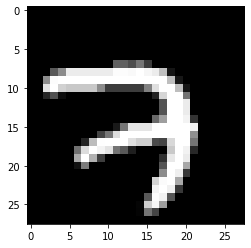

In [0]:
# Sample to plot
sample = 0

# Reshape sample from 784 to 28x28
reshaped_sample = np.reshape(data.train.images[sample], newshape=(28,28)) 
print(reshaped_sample)
# Plot reshaped sample image using grayscale color map
plt.imshow(reshaped_sample, cmap="gray") 

# Print true sample class
print (data.train.labels[sample]) 

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimized so as to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

### Placeholder variables

Here, we are defining the placeholder variables to which we will feed the inputs to the network. We firstly have **x_input** that will hold the real images from the data set, and its dimensions are None(batch size) and flattened image size. **z_input** will be fed with the noise vector which will be used for the image generation and its size is None and 100 which is the length of the noise vector. **dropout** is the keep probability of for the dropout operations, altough it is not used in the final version of the code therefore it can be ignored.

In [0]:
with tf.variable_scope('D'):
  x_input = tf.placeholder(tf.float32, [None, img_size_flat], name="x_input")
  

In [0]:
with tf.variable_scope('G'):
  z_input = tf.placeholder(tf.float32, [None, 100], name="z_input")


dropout = tf.placeholder(tf.float32, name="dropout")

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

We define the variables inside a dictionnary for easier access. The variables are created with tf.get_variable and initialized with Xavier initialization method for better performance. Both generator and the discriminators are fully connected networks with a single hiden layer with 128 units and an output layer. 

In [0]:

weights = {
    'g_fc' : tf.get_variable("DenseHiddenGenerator", [100, 128], initializer=tf.glorot_normal_initializer()),
    'g_out' : tf.get_variable("DenseOutGenerator", [128, img_size_flat], initializer=tf.glorot_normal_initializer()),
    'd_fc' : tf.get_variable("DenseHiddenDiscriminator", [img_size_flat, 128], initializer=tf.glorot_normal_initializer()),
    'd_out' : tf.get_variable("DenseOutDiscriminator", [128, 1], initializer=tf.glorot_normal_initializer())
}


'\nweights = {\n    \'g_fc\' : tf.Variable( tf.truncated_normal([100, 128]), name= "DenseHiddenGenerator"),\n    \'g_out\' : tf.Variable( tf.truncated_normal([128, img_size_flat]), name= "DenseOutGenerator"),\n    \'d_fc\' : tf.Variable( tf.truncated_normal([img_size_flat, 128]), name= "DenseHiddenDiscriminator"),\n    \'d_out\' : tf.Variable( tf.truncated_normal([128, 1]), name= "DenseOutDiscriminator")\n}\n'

We also define a dictionnary for the bias variables, which are added to the outputs of the multiplications on the layers. These variables are initialized with constant initializer which by default sets the values to 0.

In [0]:

biases = {
      'g_fc' : tf.get_variable("BiasHiddenGenerator", [128], initializer=tf.constant_initializer()),
      'g_out' : tf.get_variable("BiasOutGenerator", [img_size_flat], initializer=tf.constant_initializer()),
      'd_fc' : tf.get_variable("BiasHiddenDiscriminator", [128], initializer=tf.constant_initializer()),
      'd_out' : tf.get_variable("BiasOutDiscriminator", [1], initializer=tf.constant_initializer())
}


'\n\n\nbiases = {\n    \'g_fc\' : tf.Variable( tf.zeros(128), name= "DenseHiddenGenerator"),\n    \'g_out\' : tf.Variable( tf.zeros(img_size_flat), name= "DenseOutGenerator"),\n    \'d_fc\' : tf.Variable( tf.zeros(128), name= "DenseOutDiscriminator"),\n    \'d_out\' : tf.Variable( tf.zeros(1), name= "DenseOutDiscriminator"),\n}\n'

### Model

Our model is constituted by 2 networks; generator and discriminator. The generator takes the noise vector of size 100 as input and produces a flattened image with size 748. It uses relu activation in the hidden layer and sigmoid in the output layer. 

Also the forward pass functions are separated from the definitions of the vaariables. This is because the generator forward pass is also used in the forward pass of the discriminator. Therefore to avoid redefinitions, I have separated these parts. I have also separated the forward pass function of the discriminator.   


In [0]:
#generator variables
with tf.variable_scope('G'):
  g_hidden = weights['g_fc']
  g_out = weights['g_out']
  g_hidden_bias = biases['g_fc']
  g_out_bias = biases['g_out']

In [0]:
def generator_forward(x):
  x = tf.add(tf.matmul(x, g_hidden), g_hidden_bias)
  x = tf.nn.relu(x)

  # The dropout operation is not used in this implementation as it seems to diverge the losses much faster
  #x = tf.nn.dropout(x, dropout)
  logits = tf.add(tf.matmul(x, g_out), g_out_bias)
  x = tf.nn.sigmoid(logits)
  return x, logits


In [0]:
#discriminator variables
with tf.variable_scope('D'):
  d_hidden = weights['d_fc']
  d_out = weights['d_out']
  d_hidden_bias = biases['d_fc']
  d_out_bias = biases['d_out']

def discriminator_forward(x):
  x = tf.add(tf.matmul(x, d_hidden), d_hidden_bias)
  x = tf.nn.relu(x)
  #x = tf.nn.dropout(x, dropout)

  logits = tf.add(tf.matmul(x, d_out), d_out_bias)
  x = tf.nn.sigmoid(logits)
  return x, logits



The forward pass of the generator gives both the logits(*gen_out_logit*) and the outputs of the sigmoid function(*gen_out_sigmoid*). The activation output is the real image output therefore this is fed to the discriminator for it to evaluate this image. z_input palceholder is fed into the forward function to generate image.

In [0]:
with tf.variable_scope('G'):
  gen_out_sigmoid, gen_out_logit = generator_forward(z_input)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


The outputs of the discriminator are in the same way as the generator; altough the outputs of the activation are only used for testing purposes and for now they are redundant. *gen_out_sigmoid*, which is the generated image, is fed into the first pass of the discriminator. In the second pass, the *x_input* is fed as we also need to train the network to learn about the real images.

In [0]:
with tf.variable_scope('D'):
  disc_fake_out_sigmoid, disc_fake_out_logit = discriminator_forward(gen_out_sigmoid)
  disc_real_out_sigmoid, disc_real_out_logit = discriminator_forward(x_input)

### Cost-function to be optimized

To make the discriminator be better at classifying real and fake images, and make generator be better at generating realistic images, we define separate cost functions. We are using cross entropy as the loss functions. 

The loss function of the discriminator is the sum of two losses where the expectations are as follows: classify real images as real(0) and classify fake images as fake(1).

Contrarily, the generator tries to incraese the loss of the discriminator by aiming to make discriminator classify fake images as real(0).

In [0]:
#real is 0 and fake is 1
d_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_out_logit, labels=tf.zeros_like(disc_real_out_logit))  + tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_out_logit, labels=tf.ones_like(disc_fake_out_logit))

g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_out_logit, labels=tf.zeros_like(disc_fake_out_logit)) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


As we calculate the cross entropies for each image, we need to get a two loss values. This is done by separately averaging the contents of **d_loss** and **g_loss**.

In [0]:
d_cost = tf.reduce_mean(d_loss)
g_cost = tf.reduce_mean(g_loss)

We need to separate the weights of the 2 networks to easily update them during the training. We have put 'Discriminator' and 'Generator' prefices to the weights and biases depending on their networks.

In [0]:
disc_vars = [var for var in tf.trainable_variables() if 'Discriminator' in var.name]
gen_vars = [var for var in tf.trainable_variables() if 'Generator' in var.name]


[<tf.Variable 'DenseHiddenDiscriminator:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'DenseOutDiscriminator:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'BiasHiddenDiscriminator:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'BiasOutDiscriminator:0' shape=(1,) dtype=float32_ref>]


### Optimization method

We create two Adam optimizers for the networks and set their variable lists as the previously separated lists. The learning rates are initialized with 0.0001.

In [0]:
D_LR = 0.0001
G_LR = 0.0001

d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR).minimize(d_cost, var_list=disc_vars)
g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR).minimize(g_cost, var_list=gen_vars)

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [0]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [0]:
session.run(tf.global_variables_initializer())

### Train

There are 55.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use a small batch of images in each iteration of the optimizer.

In [0]:
batch_size = 100

In [0]:
'''
import os

if not os.path.exists('output'):
    os.makedirs('output')
'''

d_loss_epoch = []
g_loss_epoch = []
total_num_epochs = 0


Each training iteration is constituted by the training of the discriminator and the generator. We generate a noise vector for the discriminator to feed to the generator to get generated images. These images and the trainin images are then used to train the discriminator. 

Then we train the generator by generating another noise vector and feed it. The generator generates images and feeds them to the discriminator to get a prediction and the optimizer uses this prediction to update the weigths of the generator.

Every 10 epochs, the network shows outputs from the generator.

In [0]:
from time import time

def train(num_epochs):
    global total_num_epochs
    for epoch in range(1, num_epochs + 1):
      total_num_epochs = total_num_epochs + 1
      g_loss_iter = []
      d_loss_iter = []
      start_time = time()
      
      for i in range(len(data.train.images)//batch_size):
          x_batch, y_true_batch = data.train.next_batch(batch_size, shuffle=False)

          z_batch = np.random.normal(50, 100, (batch_size, 100)).astype('f')
          _, discriminator_loss, d_real_output, d_fake_output = session.run([d_optimizer, d_cost, disc_real_out_sigmoid, disc_fake_out_sigmoid], feed_dict={x_input: x_batch, z_input: z_batch, dropout:0.7})

          z_batch = np.random.normal(50, 100, (batch_size, 100)).astype('f')
          _, generator_loss = session.run([g_optimizer, g_cost], feed_dict={z_input: z_batch, dropout:0.7})

          d_loss_iter.append(discriminator_loss)
          g_loss_iter.append(generator_loss)
      d_mean_loss = np.mean(d_loss_iter)
      g_mean_loss = np.mean(g_loss_iter)
      print("Epoch {} -> Discriminator loss:{} Generator Loss:{} Elapsed time:{}s ".format(total_num_epochs, d_mean_loss, g_mean_loss, time()-start_time))
      d_loss_epoch.append(d_mean_loss)
      g_loss_epoch.append(g_mean_loss)

      if total_num_epochs % 10 == 0:
        z_batch = np.random.normal(50, 100, (9, 100)).astype('f')
        gen_images = session.run(gen_out_sigmoid, feed_dict={z_input: z_batch, dropout:1.0})
        fig=plt.figure(figsize=(10, 10))
        columns = 3
        rows = 3
        for t in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, t)
            #plt.imshow(np.reshape(gen_images[i-1], newshape=(img_size, img_size)), cmap="gray")
            plt.imshow(np.reshape(gen_images[t-1], newshape=(img_size, img_size)), cmap="gray")
              
              
        #plt.savefig("output/{}_output.png".format(str(total_num_epochs)))
        plt.show()
          


## Performance after 10 training epochs

In [0]:
train(10)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


AssertionError: ignored

## Performance after 300 training iterations


In [0]:
train(290)

## Loss plots

In [0]:
x = np.linspace(1, len(d_loss_epoch), len(d_loss_epoch))
fig = plt.figure()
plt.plot(x, d_loss_epoch, 'r', label="Discriminator")
plt.plot(x, g_loss_epoch, 'b', label="Generator")
plt.legend()
plt.title("Losses of 2 networks")
plt.show()
fig.savefig("output/loss_graph.png")

In [0]:
#zip the contents of the output directory
#!zip -r /content/file.zip /content/output

We are now done using TensorFlow, so we close the session to release its resources.

In [0]:
session.close()

## References

[1] [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)